# Pose matching using openpose

## Importing libraries (and openpose linux)

In [1]:
import sys
import cv2
import numpy as np
import argparse
import pandas as pd
import math
import copy
import time
import pickle
from itertools import zip_longest
from scipy import spatial
import matplotlib.pyplot as plt
sys.path.append('../../python')
from openpose import pyopenpose as op

## Set flags and parameters

In [9]:
# Flags
parser = argparse.ArgumentParser()
parser.add_argument("--image_dir", default="/home/mortirreke/Desktop/assets", help="Process an image. Read all standard formats (jpg, png, bmp, etc.).")
args = parser.parse_known_args()


# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = "../../../models/"
params["net_resolution"] = "320x320"
#params["write_json"] = "/home/mortirreke/Desktop/output/"

# Function for grouping list items
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    args = [iter(iterable)] * n
    return list(zip_longest(*args, fillvalue=fillvalue))

# Get body parts and pose pairs from openpose library (refer to openpose/src/openpose/pose/poseParameters.cpp for more parameters)
BODY_PARTS = op.getPoseBodyPartMapping(op.BODY_25)
POSE_PAIRS = op.getPosePartPairs(op.BODY_25)
POSE_PAIRS = grouper(POSE_PAIRS, 2, None)


for i in range(0, len(args[1])):
    curr_item = args[1][i]
    if i != len(args[1])-1: next_item = args[1][i+1]
    else: next_item = "1"
    if "--" in curr_item and "--" in next_item:
        key = curr_item.replace('-','')
        if key not in params:  params[key] = "1"
    elif "--" in curr_item and "--" not in next_item:
        key = curr_item.replace('-','')
        if key not in params: params[key] = next_item

## extract keypoints from images in a folder

In [7]:
# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()
imagePaths = op.get_images_on_directory(args[0].image_dir)

# Process Image

datum_list = []

for i, image in enumerate(imagePaths):
    # if(i == 100):
    #     break
    datum = op.Datum()
    imageToProcess = cv2.imread(image)
    datum.cvInputData = imageToProcess
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))
    network_output = datum.poseKeypoints
    datum_list.append([image, network_output])
    time.sleep(0.1)

df = pd.DataFrame(datum_list, columns=['image_path', 'keypoints'])
np.set_printoptions(linewidth=100000)


Starting OpenPose Python Wrapper...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.


## Extracting coordinates from output + cleaning

In [8]:
keypoints = [] #list with all detected poses (coordinates) and their respective file
for index,row in df.iterrows():
  network_output = row[1]
  # Unwrapping Person Keypoints from Openpose Network Output
  index_names = copy.deepcopy(BODY_PARTS)
  index_names.pop(25)
  if network_output is not None:
      count = 0
      for human in network_output:
          count += 1
          output_sub_arr = {}
          for i in range(len(human)):
              output_sub_arr[BODY_PARTS[i]]= [int(human[i][0]),int(human[i][1]), row[0]]
          print("\n   Person Detected")
          dataframe = pd.DataFrame(output_sub_arr.values(), columns=['x','y','path'], index=list(index_names.values()))
          keypoints.append(dataframe)
  else:
      print("no keypoints detected for :" + row[0])


no keypoints detected for :/home/mortirreke/Desktop/assets/011.jpg

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person Detected

   Person De

### save and load output (optional)

In [9]:
# with open('/home/mortirreke/Desktop/output/keypointsall.pickle', 'wb') as handle:
#     pickle.dump(keypoints, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('/home/mortirreke/Desktop/output/keypointsall.pickle', 'rb') as handle:
    keypoints = pickle.load(handle)

## Check if coordinates work

In [14]:
for pose in keypoints:
    test = cv2.imread(pose.iloc[0]['path'])
    for i,keypoint in pose.iterrows():
        x = keypoint["x"]
        y = keypoint["y"]
        test = cv2.circle(test, (x,y), 1, (0,0,255), -1)
    cv2.imshow("keypoints",test)
    key = cv2.waitKey(0)
    if key == 27: break
    cv2.destroyAllWindows()

# Pose Matching

## Compare similarity

In [4]:
def similarity_score(pose1:pd.DataFrame, pose2:pd.DataFrame):
    p1 = []
    p2 = []

    # Remove keypoints when keypoint values is none
    pose1_df = pd.DataFrame(pose1, columns=['x','y'])
    pose2_df = pd.DataFrame(pose2, columns=['x','y'])
    # pose_df = pd.concat([pose1, pose2],axis = 1).dropna().reset_index(drop=True)
    # pose1_df = pose1.rename({'x':})
    # pose2_df = pose_df[['Xp2','Yp2']]

    pose1 = pose1_df.to_numpy()
    pose2 = pose2_df.to_numpy()

    pose_1 = np.array(pose1, dtype=float)
    pose_2 = np.array(pose2, dtype=float)

    # Normalize coordinates
    pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
    pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
    pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
    pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

    # Turn (16x2) into (32x1)
    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]

        p1.append(x1)
        p1.append(y1)
        p2.append(x2)
        p2.append(y2)

    p1 = np.array(p1)
    p2 = np.array(p2)


    # Looking to minimize the distance if there is a match
    # Computing two different distance metrics
    cosineDistance = spatial.distance.cosine(p1, p2)
    euclideanDistance = math.sqrt(2 * cosineDistance)

    return 1 - cosineDistance

In [5]:
similarity_score(keypoints[0], keypoints[0]) #should give a score of 1...

1

## define visualisation methods

In [63]:

#expects a pandas dataframe
def visualize_pose(pose:pd.DataFrame,size = 512):
    canvas =  np.ones(shape=(size,size,3), dtype=np.int16)
    for pair in POSE_PAIRS:
        idFrom = pair[0]
        idTo   = pair[1]
        if pose.iloc[idFrom]['x'] != 0 and pose.iloc[idFrom]['y'] != 0 and pose.iloc[idTo]['x'] != 0 and pose.iloc[idTo]['y'] != 0:
            cv2.line(canvas, (pose.iloc[idFrom]['x'],pose.iloc[idFrom]['y']), (pose.iloc[idTo]['x'],pose.iloc[idTo]['y']), (0, 0, 255), 3)
    plt.imshow(canvas)
    plt.grid(True)

def visualize_poses(pose1:pd.DataFrame,pose2:pd.DataFrame,size = 512):
    canvas =  np.ones(shape=(size,size,3), dtype=np.int16)
    for pair in POSE_PAIRS:
        idFrom = pair[0]
        idTo   = pair[1]
        if pose1.iloc[idFrom]['x'] != 0 and pose1.iloc[idFrom]['y'] != 0 and pose1.iloc[idTo]['x'] != 0 and pose1.iloc[idTo]['y'] != 0:
            cv2.line(canvas, (pose1.iloc[idFrom]['x'],pose1.iloc[idFrom]['y']), (pose1.iloc[idTo]['x'],pose1.iloc[idTo]['y']), (0, 0, 255), 3)
    for pair in POSE_PAIRS:
        idFrom = pair[0]
        idTo   = pair[1]
        if pose2.iloc[idFrom]['x'] != 0 and pose2.iloc[idFrom]['y'] != 0 and pose2.iloc[idTo]['x'] != 0 and pose2.iloc[idTo]['y'] != 0:
            cv2.line(canvas, (pose2.iloc[idFrom]['x'],pose2.iloc[idFrom]['y']), (pose2.iloc[idTo]['x'],pose2.iloc[idTo]['y']), (0, 255, 0), 3)

    plt.imshow(canvas)
    plt.grid(True)


def visualize(pose1:pd.DataFrame,show_image = False,size = 512 ):

    if show_image:
        canvas = cv2.imread(pose1.iloc[0]['path'])
    else:
        canvas =  np.ones(shape=(size,size,3), dtype=np.int16)


    nose =  (pose1.loc["Nose"]['x'],pose1.loc["Nose"]['y'])
    neck =  (pose1.loc["Neck"]['x'],pose1.loc["Neck"]['y'])
    RShoulder =  (pose1.loc["RShoulder"]['x'],pose1.loc["RShoulder"]['y'])
    RElbow =  (pose1.loc["RElbow"]['x'],pose1.loc["RElbow"]['y'])
    RWrist =  (pose1.loc["RWrist"]['x'],pose1.loc["RWrist"]['y'])
    LShoulder =  (pose1.loc["LShoulder"]['x'],pose1.loc["LShoulder"]['y'])
    LElbow =  (pose1.loc["LElbow"]['x'],pose1.loc["LElbow"]['y'])
    LWrist =  (pose1.loc["LWrist"]['x'],pose1.loc["LWrist"]['y'])
    MidHip =  (pose1.loc["MidHip"]['x'],pose1.loc["MidHip"]['y'])
    RHip =  (pose1.loc["RHip"]['x'],pose1.loc["RHip"]['y'])
    RKnee =  (pose1.loc["RKnee"]['x'],pose1.loc["RKnee"]['y'])
    RAnkle =  (pose1.loc["RAnkle"]['x'],pose1.loc["RAnkle"]['y'])
    LHip =  (pose1.loc["LHip"]['x'],pose1.loc["LHip"]['y'])
    LKnee =  (pose1.loc["LKnee"]['x'],pose1.loc["LKnee"]['y'])
    LAnkle =  (pose1.loc["LAnkle"]['x'],pose1.loc["LAnkle"]['y'])
    REye =  (pose1.loc["REye"]['x'],pose1.loc["REye"]['y'])
    LEye =  (pose1.loc["LEye"]['x'],pose1.loc["LEye"]['y'])
    REar =  (pose1.loc["REar"]['x'],pose1.loc["REar"]['y'])
    LEar =  (pose1.loc["LEar"]['x'],pose1.loc["LEar"]['y'])
    LBigToe =  (pose1.loc["LBigToe"]['x'],pose1.loc["LBigToe"]['y'])
    LSmallToe =  (pose1.loc["LSmallToe"]['x'],pose1.loc["LSmallToe"]['y'])
    LHeel =  (pose1.loc["LHeel"]['x'],pose1.loc["LHeel"]['y'])
    RBigToe =  (pose1.loc["RBigToe"]['x'],pose1.loc["RBigToe"]['y'])
    RSmallToe =  (pose1.loc["RSmallToe"]['x'],pose1.loc["RSmallToe"]['y'])
    RHeel =  (pose1.loc["RHeel"]['x'],pose1.loc["RHeel"]['y'])

    if nose != (0,0) and neck != (0,0):
        cv2.line(canvas,nose,neck, (0, 0, 255), 3)
    if REye != (0,0) and nose != (0,0):
        cv2.line(canvas,nose,REye, (0, 0, 255), 3)
    if REye != (0,0) and REar != (0,0):
        cv2.line(canvas,REar,REye, (0, 0, 255), 3)

    if LEye != (0,0) and nose != (0,0):
        cv2.line(canvas,nose,LEye, (0, 0, 255), 3)
    if LEye != (0,0) and LEar != (0,0):
        cv2.line(canvas,LEar,LEye, (0, 0, 255), 3)

    # spine
    if MidHip != (0,0) and neck != (0,0):
        cv2.line(canvas,MidHip,neck, (0, 0, 255), 3)
    if MidHip != (0,0) and RHip != (0,0):
        cv2.line(canvas,MidHip,RHip, (0, 0, 255), 3)
    if MidHip != (0,0) and LHip != (0,0):
        cv2.line(canvas,MidHip,LHip, (0, 0, 255), 3)

    # Right hand
    if RShoulder != (0,0) and neck != (0,0):
        cv2.line(canvas,RShoulder,neck, (0, 0, 255), 3)
    if RElbow != (0,0) and RShoulder != (0,0):
        cv2.line(canvas,RShoulder,RElbow, (0, 0, 255), 3)
    if RWrist != (0,0) and RElbow != (0,0):
        cv2.line(canvas,RWrist,RElbow, (0, 0, 255), 3)


    # Left arm
    if neck != (0,0) and LShoulder != (0,0):
        cv2.line(canvas,LShoulder,neck, (0, 0, 255), 3)
    if LElbow != (0,0) and LShoulder != (0,0):
        cv2.line(canvas,LShoulder,LElbow, (0, 0, 255), 3)
    if LWrist != (0,0) and LElbow != (0,0):
        cv2.line(canvas,LWrist,LElbow, (0, 0, 255), 3)

    #Left leg
    if LKnee != (0,0) and LHip != (0,0):
        cv2.line(canvas,LKnee,LHip, (0, 0, 255), 3)
    if LKnee != (0,0) and LAnkle != (0,0):
        cv2.line(canvas,LKnee,LAnkle, (0, 0, 255), 3)
    if LAnkle != (0,0) and LHeel != (0,0):
        cv2.line(canvas,LHeel,LAnkle, (0, 0, 255), 3)
    if LAnkle != (0,0) and LHeel != (0,0):
        cv2.line(canvas,LBigToe,LAnkle, (0, 0, 255), 3)
    if LAnkle != (0,0) and LHeel != (0,0):
        cv2.line(canvas,LBigToe,LAnkle, (0, 0, 255), 3)
    if LSmallToe != (0,0) and LBigToe != (0,0):
        cv2.line(canvas,LBigToe,LSmallToe, (0, 0, 255), 3)

    # Right leg
    if RKnee != (0,0) and RHip != (0,0):
        cv2.line(canvas,RKnee,RHip, (0, 0, 255), 3)
    if RKnee != (0,0) and RAnkle != (0,0):
        cv2.line(canvas,RKnee,RAnkle, (0, 0, 255), 3)
    if RAnkle != (0,0) and RHeel != (0,0):
        cv2.line(canvas,RHeel,RAnkle, (0, 0, 255), 3)
    if RAnkle != (0,0) and RHeel != (0,0):
        cv2.line(canvas,RBigToe,RAnkle, (0, 0, 255), 3)
    if RAnkle != (0,0) and RHeel != (0,0):
        cv2.line(canvas,RBigToe,RAnkle, (0, 0, 255), 3)
    if RSmallToe != (0,0) and RBigToe != (0,0):
        cv2.line(canvas,RBigToe,RSmallToe, (0, 0, 255), 3)

    if show_image:
        pixels = np.array(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.imshow(pixels)
    else:
        plt.imshow(canvas)
    plt.grid(True)

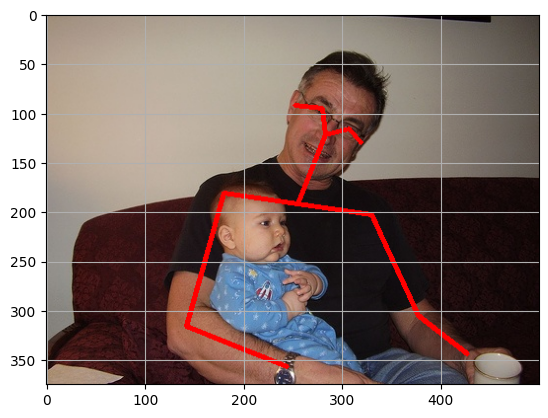

In [64]:
visualize(keypoints[15],True)

## Transform & scale

In [17]:
def scale(pose1, pose2):
    #  Rename columns and concat
    pose1 = pose1.rename(columns={"x":"Xp1", "y":"Yp1", "path":"p1"})
    pose2 = pose2.rename(columns={"x":"Xp2", "y":"Yp2", "path":"p2"})
    pose_df = pd.concat([pose1, pose2],axis = 1)

    # Cropping Pose
    pose_df['Xp1'] = pose_df['Xp1'] - pose_df['Xp1'].min()
    pose_df['Yp1'] = pose_df['Yp1'] - pose_df['Yp1'].min()
    pose_df['Xp2'] = pose_df['Xp2'] - pose_df['Xp2'].min()
    pose_df['Yp2'] = pose_df['Yp2'] - pose_df['Yp2'].min()

    # Resizing Pose
    resize_x = pose_df['Xp2'].max()/pose_df['Xp1'].max()
    resize_y = pose_df['Yp2'].max()/pose_df['Yp1'].max()

    pose_df['Xp1'] = pose_df['Xp1']*resize_x
    pose_df['Yp1'] = pose_df['Yp1']*resize_y

    # print(pose_df)

    # Get dimensions of output window
    max_y = max(pose_df['Yp1'].max(), pose_df['Yp2'].max())
    max_x = max(pose_df['Xp1'].max(), pose_df['Xp2'].max())
    # dim = (int(max_y), int(max_x), 3)



    # Convert DataFrame back to Pose lists
    pose1 = pose_df[['Xp1', 'Yp1', 'p1']]
    x = pose1.rename(columns={"Xp1":"x", "Yp1":"y", "p1":"path"})
    x = x.astype({'x':'int', 'y':'int'})

    pose2 = pose_df[['Xp2','Yp2', 'p2']]
    y = pose2.rename(columns={"Xp2":"x", "Yp2":"y", "p2":"path"})
    y = y.astype({'x':'int', 'y':'int'})

    return x,y
    # return pose1,pose2
# Visualize and Calculate similarity score again
# visualize_output(pose1_new, pose2_new, dim)
# similarity_score(pose1_df, pose2_df)

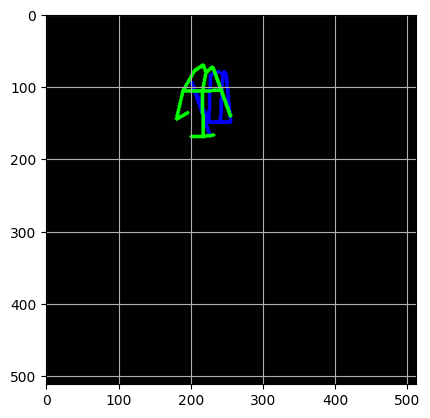

In [18]:
# visualize_poses(pandas_keypoints[42],pandas_keypoints[41])
p1,p2 = scale(keypoints[0], keypoints[1])
visualize_poses(p1,p2)

## Compare all scores to each other

In [218]:
similarity_scores = []

for pose1 in keypoints:
    for pose2 in keypoints:
        if pose1 is not pose2:
        #     sp1,sp2 = scale(pose1,pose2)
            score = similarity_score(pose1,pose2)
            similarity_scores.append((score,pose1,pose2))

KeyboardInterrupt: 

## Sort results and display them

In [220]:
similarity_scores.sort(key=lambda tup: tup[0],reverse=True)
for result in similarity_scores:
    pose1 = result[1]
    pose2 = result[2]

    im1 = cv2.imread(pose1.iloc[0]['path'])
    im2 = cv2.imread(pose2.iloc[0]['path'])
    for i,keypoint in pose1.iterrows():
        x = keypoint['x']
        y = keypoint['y']
        im1 = cv2.circle(im1, (x,y), 3, (0,0,255), -1)

    for i,keypoint in pose2.iterrows():
        x = keypoint['x']
        y = keypoint['y']
        im2 = cv2.circle(im2, (x,y), 3, (0,0,255), -1)

    im2 = cv2.putText(im2, str(result[0]), (0,30), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0,0,255), 1, 2)

    cv2.imshow("image1",im1)
    cv2.imshow("image2",im2)
    key = cv2.waitKey(0)
    if key == 27: break

    cv2.destroyAllWindows()
cv2.destroyAllWindows()

## find best match for a given image

In [231]:

pose1 = keypoints[654]
similarity_scores = []
for pose2 in keypoints:
    if pose1 is not pose2:
        score = similarity_score(pose1,pose2)
        similarity_scores.append((score,pose1,pose2))

similarity_scores.sort(key=lambda tup: tup[0],reverse=True)
for result in similarity_scores:
    pose1 = result[1]
    pose2 = result[2]

    im1 = cv2.imread(pose1.iloc[0]['path'])
    im2 = cv2.imread(pose2.iloc[0]['path'])
    for i,keypoint in pose1.iterrows():
        x = keypoint['x']
        y = keypoint['y']
        im1 = cv2.circle(im1, (x,y), 3, (0,0,255), -1)

    for i,keypoint in pose2.iterrows():
        x = keypoint['x']
        y = keypoint['y']
        im2 = cv2.circle(im2, (x,y), 3, (0,0,255), -1)

    im2 = cv2.putText(im2, str(result[0]), (0,30), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0,0,255), 1, 2)

    cv2.imshow("image1",im1)
    cv2.imshow("image2",im2)
    key = cv2.waitKey(0)
    if key == 27: break

    cv2.destroyAllWindows()
cv2.destroyAllWindows()
